# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [ ]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [ ]:
# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# Model Selection and Evaluation Libraries
from sklearn.model_selection import train_test_split, GridSearchCV  # For splitting data and hyperparameter tuning
from sklearn.metrics import mean_squared_error, mean_absolute_error  # To evaluate model performance

# Surprise-specific Libraries and Tools
from surprise import Reader, Dataset  # To load dataset for Surprise-based models
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans  # For user-user/item-item similarity-based models
from surprise import accuracy
from surprise.model_selection import KFold # For implementing cross validation

# Libraries for data management
import pickle
import os
import sys
import gc

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
path = "/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/ratings_Electronics.csv"

df = pd.read_csv(path, names=['user_id', 'prod_id', 'rating', 'timestamp'])
df.drop('timestamp', axis=1, inplace=True)   # I'm not using 'timestamp' for this analysis


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Load the dataset if already in existence (from previous sessions), and create if not

# Path to the saved dataset
saved_file_path = '/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/Models and Datasets/df_final.pkl'

# Check if the file exists and load it; otherwise, create the dataset
if os.path.exists(saved_file_path):
    # Load the dataset from the pickle file
    df_final = pd.read_pickle(saved_file_path)
    print("Loaded saved dataset from Google Drive.")
else:
    print("Saved dataset not found. Creating new dataset...")

    # Filter out products with fewer than 5 ratings
    prod_counts = df['prod_id'].value_counts()
    remove_prods = prod_counts[prod_counts < 5].index
    df_intermediate = df.loc[~df.prod_id.isin(remove_prods)]

    # Now filter out users with fewer than 50 ratings using the intermediate DataFrame
    user_counts = df_intermediate['user_id'].value_counts()
    remove_users = user_counts[user_counts < 50].index
    df_final = df_intermediate.loc[~df_intermediate.user_id.isin(remove_users)]

# Examine features of the dataset

# Check the final counts for users and products
user_counts_final = df_final['user_id'].value_counts()
prod_counts_final = df_final['prod_id'].value_counts()

print("User Counts:\n", user_counts_final.tail())
print("\nProduct Counts:\n", prod_counts_final.tail())

print("-"*50)
df_final.shape    # To check the size of the new filtered dataset

Loaded saved dataset from Google Drive.
User Counts:
 A1ZPUEHF4AES86    50
AR1T36GLLAFFX     50
AW6FQE5QRF2LM     50
A1FOSIV4TWZFR7    50
AN0JK8OQLUC55     50
Name: user_id, dtype: int64

Product Counts:
 B0029ILMTE    1
B0029HPSNG    1
B0029F21JW    1
B0029EBLMG    1
B0038X9VPG    1
Name: prod_id, dtype: int64
--------------------------------------------------


(107263, 3)

Each time we remove products below the 5 review threshold, we end up with additional users who fall below the 50 review threshold.  Conversely, each time we remove users who are below the 50 review threshold, we reduce the number of products that meet the 5 review threshold.  Therefore, we (probably) cannot totally remove both thresholds unless the dataset aligns well, and I will prioritize getting users with 50 reviews.   This filter has reduced the dataset size to 107,263, which is a bit less than 1.4% of the original.  This might be too aggressive a cut, but I will examine this final dataset to see what insights may be gleaned.

In [ ]:
'''
# Specify the file path for the dataset
dataset_file_path = '/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/Models and Datasets/df_final.pkl'

# Save the dataset to disk using pickle
df_final.to_pickle(dataset_file_path)
'''

## **Exploratory Data Analysis**

### **Review the look and shape of the dataset**

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0
631,A3TAS1AG6FMBQW,0972683275,5.0


In [ ]:
# Check the number of rows and columns and provide observations
df_final.shape

(107263, 3)

As noted previously, we have 107,263 entries in three columns, with user_id, prod_id, and rating.

### **Data types**

In [ ]:
# Check data types
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

In [ ]:
# Confirming the range that the 'rating' variable can take

df_final["rating"].value_counts()

5.0    59943
4.0    28236
3.0    10430
2.0     4534
1.0     4120
Name: rating, dtype: int64

**Observations**

The 'user_id' and 'prod_id' are objects and 'rating' is a float.  This is fine and I don't necessarily need to change any of those.  'prod_id' has alphanumeric characters and leading 0s, so I will keep it as is. Though it won't make a big difference, all of my ratings are integers so I will convert the datatype to integer.  Because some of the checks I do below are based on particular user_ids, I will not use a Label Encoder on them.  They are short enough that I don't expect it to increase my processing time too greatly.

In [ ]:
# Convert 'rating' from float to integer
df_final['rating'] = df_final['rating'].astype(int)


### **Checking for missing values, duplicate values, and unique observations**

In [ ]:
# Check for missing values present and provide observations
df_final.info()

# Check for duplicate values
num_duplicates = df_final.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")

# Check for unique values in user_id and prod_id
print("\nFinal Dataset")
print(f"\nNumber of unique users: {df_final['user_id'].nunique()}")
print(f"\nNumber of unique products: {df_final['prod_id'].nunique()}")

# Check for unique values in user_id and prod_id in the original, unfiltered dataset for comparison
print("\nOriginal Dataset")
print(f"\nNumber of unique users in unfiltered dataset: {df['user_id'].nunique()}")
print(f"\nNumber of unique products in unfiltered dataset: {df['prod_id'].nunique()}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107263 entries, 118 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  107263 non-null  object
 1   prod_id  107263 non-null  object
 2   rating   107263 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.3+ MB

Number of duplicate rows: 0

Final Dataset

Number of unique users: 1320

Number of unique products: 36915

Original Dataset

Number of unique users in unfiltered dataset: 4201696

Number of unique products in unfiltered dataset: 476002


**Observations**

- There are no nulls and no duplicates, which is great.
- The data is extremely sparse, even having filtered the original dataset for users and products with a large amount of interactions.  With 36,915 products and 1,320 users, the potential user-item matrix would have about 48.7 million possible interactions, of which only 107,263 are known (a sparsity of about 99.78%).
- I am again concerned about having a relatively small and still sparse dataset, particularly when it comes to building a collaborative filtering model. I'm especially uncomfortable with only 1320 unique users.
-I ultimately create two main datasets for this part, both of which filter out products with fewer than 5 ratings, but df_final filters out users with fewer than 50 reviews and df_new filters out users with fewer than 30 reviews, relaxing the threshold to increase the number of unique users from ~1300 to ~4400.  
**Note**: *Trial and error demonstrates that df_new performs significantly better than df_final, though with it being larger I ended up running into RAM issues.  Now that I've improved my memory management system, I can use the more effective df_new.  For example, the first model trained on df_final had an F_1 of 0.79 compared to the 0.85 of the first one trained on df_new

In [ ]:
# Creating new dataframe called df_new

# Filter out products with fewer than 5 ratings
prod_counts = df['prod_id'].value_counts()
remove_prods = prod_counts[prod_counts < 5].index
df_intermediate = df.loc[~df.prod_id.isin(remove_prods)]

# Now filter out users with fewer than 30 ratings using the intermediate DataFrame
user_counts = df_intermediate['user_id'].value_counts()
remove_users = user_counts[user_counts < 30].index
df_new = df_intermediate.loc[~df_intermediate.user_id.isin(remove_users)]

# Check the final counts for users and products
user_counts_new = df_new['user_id'].value_counts()
prod_counts_new = df_new['prod_id'].value_counts()

print("New User Counts:\n", user_counts_new.tail())
print("\nNew Product Counts:\n", prod_counts_new.tail())

print("-"*50)
df_new.shape    # To check the size of the new filtered dataset

# Check for unique values in user_id and prod_id
print("New Dataset")
print(f"\nNumber of unique users in new dataset: {df_new['user_id'].nunique()}")
print(f"\nNumber of unique products in new dataset: {df_new['prod_id'].nunique()}")


New User Counts:
 A1A2F1ZOWOPNJB    30
A2KZQEKUS3G02I    30
A1Q33MTP73V4QJ    30
A18KLWANZOBG0J    30
A2XXCCT0TBVDIE    30
Name: user_id, dtype: int64

New Product Counts:
 B00451A15Y    1
B00450K36W    1
B00450AD7Q    1
B0044ZVH9A    1
0594451647    1
Name: prod_id, dtype: int64
--------------------------------------------------
New Dataset

Number of unique users in new dataset: 4409

Number of unique products in new dataset: 58550


This new dataset has some 4400 unique users instead of only 1300 some.  Though the dataset is even sparser, I feel better with having 3 x more users.

There are also now 58,550 unique products instead of almost 37,000.

In [22]:
# Making the same changes to the datatypes as I did for df_final

# Convert 'rating' from float to integer
df_new['rating'] = df_new['rating'].astype(int)


In [ ]:
# Saving df_new

# Specify the file path for the dataset
dataset_file_path = '/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/Models and Datasets/df_new.pkl'

# Save the dataset to disk using pickle
df_new.to_pickle(dataset_file_path)

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable on original dataset for comparison
print("ORIGINAL DATASET")
df.describe().T


ORIGINAL DATASET


,count,mean,std,min,25%,50%,75%,max
rating,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


In [ ]:
# Summary statistics of 'rating' variable on df_final dataset
print("DF_FINAL DATASET")
df_final['rating'].describe().to_frame().T

DF_FINAL DATASET


,count,mean,std,min,25%,50%,75%,max
rating,107263.0,4.261833,1.049907,1.0,4.0,5.0,5.0,5.0


**Observations**

The final dataset is skewed to the left, with a mean of 4.26, the median rating already being the highest of '5, and even the first quartile is a '4'.  This is even more skewed than the original unfiltered dataset, having a slightly higher mean, with a tighter standard deviation.  

### **Checking the rating distribution**

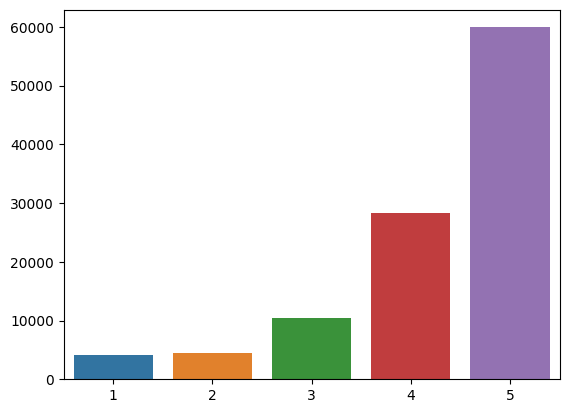

5    0.558841
4    0.263241
3    0.097238
2    0.042270
1    0.038410
Name: rating, dtype: float64

In [ ]:
# Bar plot of ratings
sns.barplot(x=df_final['rating'].value_counts().index, y=df_final['rating'].value_counts().values)
plt.show()

perc = df_final['rating'].value_counts(normalize=True)
perc

**Observations**

This provides visible corroboration of the left-skewedness of the dataset.  A significant majority of the ratings are '5', with relatively very few '1's, '2's, and '3's.  ~57% of the ratings are '5', ~24% are '4's, and '1's, '2's, and '3's altogether comprise only ~18% of the ratings.  This may be because of a general tendency to be more generous with ratings or because the filtered dataset is composed of the products with the most interactions, which may also be the most popular and therefore tend to be higher-rated.

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
user_ratings = df_final.value_counts(["user_id"])

print("Top 10 users based on the number of ratings")
user_ratings.head(10)

Top 10 users based on the number of ratings


user_id       
ADLVFFE4VBT8      468
A5JLAU2ARJ0BO     463
A3OXHLG6DIBRW8    456
A6FIAB28IS79      412
A680RUE1FDO8B     381
A1ODOGXEYECQQ8    360
A36K2N527TXXJN    296
AWPODHOB4GFWL     293
ARBKYIVNYWK3C     285
A25C2M3QF9G7OQ    280
dtype: int64

**Observations**

The top user based on number of ratings has 468 ratings, and the top 4 have over 400 each.  By number 10, the number of ratings has fallen to 280.  The top users definitely each have a significant number of product reviews.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
average_ratings = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
ratings_count = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
ratings_df = pd.concat([average_ratings, ratings_count], axis=1)
ratings_df.columns = ['average_rating', 'rating_count']

# Sort the dataframe by average of ratings in the descending order
ratings_df.sort_values(by='average_rating', ascending=False, inplace=True)

# See the first five records of the "final_rating" dataset
ratings_df.head()

,average_rating,rating_count
prod_id,,
B0038X9VPG,5.0,1
B003KN3IXU,5.0,1
B003KRQUGS,5.0,1
B003KRBVJE,5.0,1
B003KR3Q4M,5.0,1


In [ ]:
# Define the function to get top n products
def top_n_prods(data, n, min_interaction=50):
    # Finding products with a minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

    # Sorting values w.r.t. average rating
    recommendations = recommendations.sort_values(by='average_rating', ascending=False)

    # Return the top n product indices
    return recommendations.head(n).index

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
# Get the top 5 product IDs
top_product_ids = top_n_prods(ratings_df, 5, 50)

# Select the corresponding rows from ratings_df
top_products_df = ratings_df.loc[top_product_ids]

# Display the DataFrame with 'prod_id', 'rating_count', and 'average_rating'
top_products_df

,average_rating,rating_count
prod_id,,
B001TH7GUU,4.927536,69
B0019EHU8G,4.880000,75
B003ES5ZUU,4.862857,175
B000QUUFRW,4.813333,75
B006W8U2MU,4.807692,52


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
# Get the top 5 product IDs with 100 minimum interactions
top_product_ids = top_n_prods(ratings_df, 5, 100)

# Select the corresponding rows from ratings_df
top_products_df = ratings_df.loc[top_product_ids]

# Display the DataFrame with 'prod_id', 'rating_count', and 'average_rating'
top_products_df

,average_rating,rating_count
prod_id,,
B003ES5ZUU,4.862857,175
B000N99BBC,4.772727,154
B007WTAJTO,4.676056,142
B004CLYEDC,4.657895,114
B00834SJNA,4.495327,107


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

In [ ]:
'''
# Defining model name
filename = '/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/Models and Datasets/model.pkl/ratings_df.pkl'

# Save the model to disk
with open(filename, 'wb') as file:
    pickle.dump(ratings_df, file)
'''

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [23]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

- The below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [24]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [25]:
# Import the necessary classes
from surprise import Dataset, Reader

# Create a Reader object
reader = Reader(rating_scale=(1, 5))

# Load the DataFrame into DatasetAutoFolds
data = Dataset.load_from_df(df_new[['user_id', 'prod_id', 'rating']], reader)

# Perform the train/test split (80% train, 20% test)
trainset, testset = train_test_split(data, test_size=0.20)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [26]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',  # similarity measure
    'user_based': True  # compute similarities between users
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
algo = KNNBasic(sim_options=sim_options, verbose=False, random_state = 1)

# Fit the model on the training data
model2 = algo.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(model2, k = 10, threshold = 3.5)

RMSE: 1.1403
Precision:  0.831
Recall:  0.871
F_1 score:  0.851


Results on df_new
RMSE: 1.1403
Precision:  0.831
Recall:  0.871
F_1 score:  0.851

Results on df_final
RMSE: 1.14
Recall: 0.75
Precision: 0.84
F_1 score: 0.793

**Observations**

The F_1 score for this model of 0.851 seems quite good for a first pass.  The RMSE of ~1.14 does seem pretty high for a 5 point rating scale where the vast majority of the observations are rating 4 or 5.  

The Recall indicates that of all the relevant products, 83% are recommended.  The Precision indicates that out of all the recommended products, 87% are relevant.  

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [27]:

# Predicting rating for a sample user with an interacted product
predicted_rating = model2.predict(uid="A3LDPF5FMB782Z", iid='1400501466', r_ui=5, verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.57   {'actual_k': 7, 'was_impossible': False}


**Observations**

The result was that the model predicted a rating of 3.57 when the actual was 5.  This is quite far off, especially when the majority of the reviews are '4's and '5's.

**Note**: *Compare this to estimate of 3.33 when using df_final*

Not a great result.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [28]:
# Find unique user_id where prod_id is not equal to "1400501466"

# Filter the DataFrame to find users where prod_id is not "1400501466"
users_not_rated_specific_product = df_new[df_new['prod_id'] != '1400501466']['user_id'].unique()

# Select the first user from the filtered list
unique_user_id = users_not_rated_specific_product[0] if len(users_not_rated_specific_product) > 0 else None

# unique_user_id will be one user_id that meets the criteria or None if no such user exists
unique_user_id

'A3BY5KCNQZXV5U'

* It can be observed from the above list that **user "A3BY5KCNQZXV5U" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A3BY5KCNQZXV5U` and `prod_id=1400501466`.**

In [29]:
# Predicting rating for a sample user with a non interacted product
predicted_rating = model2.predict(uid="A3BY5KCNQZXV5U", iid='1400501466', verbose=True)

user: A3BY5KCNQZXV5U item: 1400501466 r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}


**Observations**

The model, when trained on df_final, produced an estimate of '3'.  This new version seems much more accurate, though it's based on an 'actual_k' of only 1.

The model predicted that user A3BY5KCNQZXV5U would rate product 1400501466 as a '5', which seems likely given the rating distribution skewing heavily to '4's and '5's.  

I'm going to do some hyperparameter tuning to determine if this model can be improved.

In [ ]:
'''
# Defining model name
filename = '/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/Models and Datasets/model.pkl/model2.pkl'

# Save the model to disk
with open(filename, 'wb') as file:
    pickle.dump(model2, file)
'''

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [30]:

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [5, 20, 40], 'min_k': [2, 5, 8],
              'sim_options': {'name': ['msd', 'cosine', 'Pearson'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])



1.0712476570572467
{'k': 40, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [31]:

# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
model2_opt = KNNBasic(sim_options=sim_options, k=40, min_k=5, verbose=False, random_state = 1)

# Training the algorithm on the train set
model2_opt.fit(trainset)

# Let us compute precision@k and recall@k
precision_recall_at_k(model2_opt)


RMSE: 1.0708
Precision:  0.826
Recall:  0.899
F_1 score:  0.861


**Observations**
The values on the original optimized model based on df_final were:
RMSE: 1.0430
Precision:  0.837
Recall:  0.72
F_1 score:  0.774

The original non-optimized values based on df_new were:
RMSE: 1.1403
Precision:  0.831
Recall:  0.871
F_1 score:  0.851

The optimized model based on df_new are:
RMSE: 1.0708
Precision:  0.826
Recall:  0.899
F_1 score:  0.861

Here we see massive improvements over the model trained on df_final, and modest but still significant improvements over the non-optimized model based on df_new.   Let's have it perform some example predictions.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [32]:
# Use model2_opt model to recommend for a known user-item interaction: userId "A3LDPF5FMB782Z" and productId 1400501466
predicted_rating = model2_opt.predict(uid="A3LDPF5FMB782Z", iid='1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.57   {'actual_k': 7, 'was_impossible': False}


This found 7 neighbors and estimate 3.57, which is not great for an actual of 5 given the distribution of the dataset, but an improvement over the 3.33 estimated by the model based on df_final.

In [33]:
# Use model2_opt model to recommend for unknown user-item interaction: userId "A34BZM6S9L7QI4" and productId "1400501466"
predicted_rating = model2_opt.predict(uid="A34BZM6S9L7QI4", iid='1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.27   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


**Observations**

This optimized model seems to be performing fairly well now that I have built it around df_new instead of df_final.  Let's save it and use it to identify nearest neighbors.

In [ ]:
'''
# Defining model name
filename = '/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/Models and Datasets/model2_opt.pkl'

# Save the model to disk
with open(filename, 'wb') as file:
    pickle.dump(model2_opt, file)
'''

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `cosine similarity` distance metric.

In [35]:

# User internal ID
user_inner_id = 0

# Number of neighbors
k = 5

# Find the 5 nearest neighbors
neighbors = model2_opt.get_neighbors(user_inner_id, k=k)

# Convert internal user IDs to raw user IDs
neighbors_raw_ids = [model2_opt.trainset.to_raw_uid(inner_id) for inner_id in neighbors]

# Display the raw user IDs of the neighbors
print(neighbors_raw_ids)


['A28525P0S5ZVJ3', 'AUCISQA1YXX86', 'A3VIS4P126GF0F', 'A2DJFYBB2L5VSN', 'A108XABRHAA9E7']


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [36]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [37]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
get_recommendations(df_new, 'A3LDPF5FMB782Z', 5, model2_opt)

[('B00004XOM3', 5),
 ('B00005LEN4', 5),
 ('B000067RT6', 5),
 ('B00006RVPW', 5),
 ('B00009R6JT', 5)]

In [38]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"

# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_new, 'A3LDPF5FMB782Z', 5, model2_opt)

# Convert the list of recommendations to a DataFrame
recommendations_df = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_rating'])

# Display the DataFrame
print(recommendations_df)

      prod_id  predicted_rating
0  B00004XOM3                 5
1  B00005LEN4                 5
2  B000067RT6                 5
3  B00006RVPW                 5
4  B00009R6JT                 5


I now have a functioning user-user similarity based recommendation system, with an estimated performance of 86%, based on the F_1 score.

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.
* First, based on previous experimentation, I will need to filter my dataset differently to accommodate an item-item based model within my RAM processing constraints, as df_final has ~40k unique products, which is too much to handle here.  I will run a calculation to determine how many different products I will get at a given threshold of number of ratings, and then filter the dataset based on that, keeping in mind that the number will decrease as I filter out users as well.

In [ ]:
# Calculate the count of ratings for each product
prod_rating_counts = df['prod_id'].value_counts()

# Convert this to a DataFrame for easier analysis
prod_rating_counts_df = pd.DataFrame({'prod_id': prod_rating_counts.index, 'rating_count': prod_rating_counts.values})

# Display the first few rows to understand the data
print(prod_rating_counts_df.head())

# Summary statistics to help decide the filtering threshold
print(prod_rating_counts_df['rating_count'].describe())

# You can also see how many products have at least X ratings
for threshold in [20, 30, 50, 80, 100]:
    num_prods = len(prod_rating_counts_df[prod_rating_counts_df['rating_count'] >= threshold])
    print(f"Number of products with at least {threshold} ratings: {num_prods}")


      prod_id  rating_count
0  B0074BW614         18244
1  B00DR0PDNE         16454
2  B007WTAJTO         14172
3  B0019EHU8G         12285
4  B006GWO5WK         12226
count    476002.000000
mean         16.437918
std         112.702633
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max       18244.000000
Name: rating_count, dtype: float64
Number of products with at least 20 ratings: 57791
Number of products with at least 30 ratings: 41214
Number of products with at least 50 ratings: 26226
Number of products with at least 80 ratings: 16648
Number of products with at least 100 ratings: 13204


In [39]:
# After some trial and error, it looks like filtering by products with at least 50 ratings produces a good dataset size within the limitations of my memory
# I relax the number of interactions per user in order to keep a larger number of them within the set

# First I'll load the saved dataset, but conditionally re-create the dataset if necessary

# Path to the saved dataset
saved_file_path = '/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/Models and Datasets/df_item_based.pkl'

# Check if the file exists and load it; otherwise, create the dataset
if os.path.exists(saved_file_path):
    # Load the dataset from the pickle file
    df_item_based = pd.read_pickle(saved_file_path)
    print("Loaded saved dataset from Google Drive.")
else:
    print("Saved dataset not found. Creating new dataset...")

    # Your existing code to create the dataset
    # Filter out products with fewer than 50 ratings from the original DataFrame 'df'
    prod_counts = df['prod_id'].value_counts()
    remove_prods = prod_counts[prod_counts < 50].index
    df_intermediate = df.loc[~df.prod_id.isin(remove_prods)]

    # Now filter out users with fewer than 20 ratings using the intermediate DataFrame
    user_counts = df_intermediate['user_id'].value_counts()
    remove_users = user_counts[user_counts < 20].index
    df_item_based = df_intermediate.loc[~df_intermediate.user_id.isin(remove_users)]

    # Convert 'rating' from float to integer (if necessary)
    df_item_based['rating'] = df_item_based['rating'].astype(int)


print("-"*50)
# Show stats for dataset
# Check for unique values in user_id and prod_id
print("\nItem_based Dataset")
print(f"\nNumber of unique users: {df_item_based['user_id'].nunique()}")
print(f"\nNumber of unique products: {df_item_based['prod_id'].nunique()}")

print("-"*50)
print("\nDataset shape")
print(df_item_based.shape)  # To check the size of the new filtered dataset


Loaded saved dataset from Google Drive.
--------------------------------------------------

Item_based Dataset

Number of unique users: 5482

Number of unique products: 22070
--------------------------------------------------

Dataset shape
(177556, 3)


In [41]:
# Previous dataset for comparison
print("\nPrevious Dataset for comparison")
print(f"\nNumber of unique users: {df_new['user_id'].nunique()}")
print(f"\nNumber of unique products: {df_new['prod_id'].nunique()}")


Previous Dataset for comparison

Number of unique users: 4409

Number of unique products: 58550


My new item_based dataset has significantly fewer products (~22k), each with more ratings, so that the item-based similarity model can run.  The number of unique users has increased roughly 4-fold compared to the previous dataset.

In [ ]:
'''
# Saving the dataset for future use

# Specify the file path for the dataset
dataset_file_path = '/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/Models and Datasets/df_item_based.pkl'

# Save the dataset to disk using pickle
df_item_based.to_pickle(dataset_file_path)
'''

"\n# Saving the dataset for future use\n\n# Specify the file path for the dataset\ndataset_file_path = '/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/Models and Datasets/df_item_based.pkl'\n\n# Save the dataset to disk using pickle\ndf_item_based.to_pickle(dataset_file_path)\n"

In [ ]:
# Loading or Creating item-item similarity-based collaborative filtering recommendation system

# Path to the saved model
saved_file_path = '/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/Models and Datasets/model_item_item.pkl'

# Check if the file exists and load it; otherwise, create the model
if os.path.exists(saved_file_path):
    # Load the dataset from the pickle file
    model_item_item = pd.read_pickle(saved_file_path)
    print("Loaded saved model from Google Drive.")
else:
    # Instantiating Reader scale with expected rating scale
    reader = Reader(rating_scale=(1, 5))

    # Loading the rating dataset
    data = Dataset.load_from_df(df_item_based[['user_id', 'prod_id', 'rating']], reader)

    # Splitting the data into train and test datasets
    trainset, testset = train_test_split(data, test_size=0.20)

    # Declaring the similarity options and making it item-based
    sim_options = {'name': 'MSD',   # Using MSD as it is more memory efficient
                  'user_based': False}

    # KNN algorithm is used to find desired similar items. Use random_state=1
    model_item_item = KNNBasic(sim_options=sim_options, k=10, verbose=False, random_state=1)

    # Train the algorithm on the trainset, and predict ratings for the test set
    model_item_item.fit(trainset)


Loaded saved model from Google Drive.


In [ ]:
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(model_item_item, k = 10)

RMSE: 1.1287
Precision:  0.826
Recall:  0.895
F_1 score:  0.859


**Observations:**

This is a pretty strong model, with an F_1 score of 85.9%. The RMSE is on the high side, with ~1.13 being a pretty big range given that most ratings are '4' or '5'.

RMSE: 1.1287
Precision:  0.826
Recall:  0.895
F_1 score:  0.859

In [ ]:
#Saving model for later use

import pickle

# Defining model name
filename = '/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/Models and Datasets/model_item_item.pkl'

# Save the model to disk
with open(filename, 'wb') as file:
    pickle.dump(model_item_item, file)

In [42]:
# Clearing my cache to free up enough system RAM in order to run the GridSearch

import sys

# Get a list of all variables in global scope and their sizes
variable_sizes = [(name, sys.getsizeof(value)) for name, value in globals().items()]

# Sort the list by size in descending order
sorted_variable_sizes = sorted(variable_sizes, key=lambda x: x[1], reverse=True)

# Display the names of the variables and their sizes
for name, size in sorted_variable_sizes[:10]:
    print(f"{name}: {size} bytes")


df: 1140356749 bytes
df_intermediate: 1118565116 bytes
user_counts: 451062665 bytes
remove_users: 283401063 bytes
prod_counts: 35700166 bytes
df_new: 33915642 bytes
df_item_based: 27296566 bytes
remove_prods: 21320689 bytes
df_final: 16489049 bytes
prod_counts_new: 4391266 bytes


In [43]:
import gc

# Delete the expensive variables I'm not using anymore
del user_counts, remove_users, prod_counts, remove_prods
del prod_counts_new, df, df_intermediate

# Run the garbage collector
gc.collect()


156

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
predicted_rating = model_item_item.predict(uid="A3LDPF5FMB782Z", iid='1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 5.00   {'actual_k': 10, 'was_impossible': False}


**Observations**

The model_item_item has the best performance so far in terms of accurately predicting the already interacted-with product, correctly predicting the rating of '5'.  This is great!

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
predicted_rating = model_item_item.predict(uid="A34BZM6S9L7QI4", iid='1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.83   {'actual_k': 3, 'was_impossible': False}


**Observations:**

We actually get a prediction here (4.83), which is nice, and the estimate seems reasonable given that most ratings are '4' or '5'.  This model appears to be performing well.

### **Hyperparameter tuning the item-item similarity-based model**
- I made a number of adjustments to the parameters I consider due to RAM constraints, and only run the grid search on a sample of 10% of the dataframe
- I use the following values for the param_grid and tune the model.
  - 'k': [5, 10, 20]
  - 'min_k': [3, 6]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# I will need to sample the dataset to get past the RAM limitations

# Sample a fraction of the dataset (Needed because of RAM limitations)
sample_fraction = 0.1  # Adjust this as needed
sampled_df = df_item_based.sample(frac=sample_fraction)

# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(sampled_df[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.20)

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [5, 10, 20], 'min_k': [3, 6],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]},
                              'verbose': [False]
              }
# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=2, n_jobs=1) # I have to accept slower processing to get past my RAM constraints

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])



1.0609563753436044
{'k': 5, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}, 'verbose': False}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

RMSE: 1.0609563753436044
Parameters:
{'k': 5, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Resetting the training set to be on the full df_item_based rather than the sample

# Instantiating Reader scale with the full dataset
reader = Reader(rating_scale=(1, 5))

# Loading the full dataset
data = Dataset.load_from_df(df_item_based[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.20)

# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
model_item_item_opt = KNNBasic(sim_options=sim_options, k=5, min_k=3, verbose=False, random_state=1)

# Training the algorithm on the trainset
model_item_item_opt.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(model_item_item_opt)


RMSE: 1.0817
Precision:  0.827
Recall:  0.928
F_1 score:  0.875


**Observations**

This is a pretty solid model, with an F_1 score of 87.5% and am RMSE of ~1.08.  This has worked pretty well and I will save the model.

In [ ]:
# Defining model name
filename = '/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/Models and Datasets/model_item_item_opt.pkl'

# Save the model to disk
with open(filename, 'wb') as file:
    pickle.dump(model_item_item_opt, file)

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Predicting rating for a sample user with an interacted product

# Use model_item_item_opt to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
predicted_rating = model_item_item_opt.predict(uid="A3LDPF5FMB782Z", iid='1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 5.00   {'actual_k': 5, 'was_impossible': False}


In [ ]:
# Predicting rating for a sample user with a non-interacted product

# Use model_item_item_opt to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
predicted_rating = model_item_item_opt.predict(uid="A34BZM6S9L7QI4", iid='1400501466', verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.59   {'actual_k': 4, 'was_impossible': False}


**Observations**

This model appears to be performing well.  Its prediction on the known user-item pair was perfect, and its prediction on the unknown user-item pair was very reasonable given the distribution of the dataset and the predictions by the other models, and was based on 4 neighbors.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
# User internal ID
user_inner_id = 0

# Number of neighbors
k = 5

# Find the 5 nearest neighbors
neighbors = model_item_item_opt.get_neighbors(user_inner_id, k=k)

# Convert internal user IDs to raw user IDs
neighbors_raw_ids = [model_item_item_opt.trainset.to_raw_uid(inner_id) for inner_id in neighbors]

# Display the raw user IDs of the neighbors
print(neighbors_raw_ids)

['A4D5B7Q8A7PA6', 'A1X9NDNOVCABX3', 'A3VI2VETB90ZG5', 'ABIVKBMSIPEDY', 'A2MOD50IHEDH3G']


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
get_recommendations(df_item_based, 'A1A5KUIIIHFF4U', 5, model_item_item_opt)

[('B000067RT6', 5),
 ('B00006L4F1', 5),
 ('B00006RVPW', 5),
 ('B0002GX0ZE', 5),
 ('B00061UISM', 5)]

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"

# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_item_based, 'A3LDPF5FMB782Z', 5, model_item_item_opt)

# Convert the list of recommendations to a DataFrame
recommendations_df = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_rating'])

# Display the DataFrame
print(recommendations_df)

      prod_id  predicted_rating
0  B00004WCIA                 5
1  B00006B7DA                 5
2  B00006HSML                 5
3  B00007GQLS                 5
4  B00009R6K7                 5


Now we have an optimized item similarity-based model that can produce a dataframe of products recommended for a particular user, along with their predicted ratings.

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [44]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_new[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.20)

# Using SVD matrix factorization
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 1.0051
Precision:  0.827
Recall:  0.866
F_1 score:  0.846


RMSE: 1.0051
Precision:  0.827
Recall:  0.866
F_1 score:  0.846

**Observations**

This is a solidly accurate model, with an F_1 score of 84.6% and an RMSE a touch over 1.0, specifically 1.0051. These are similar metrics to my other models. Let's see how it performs with specific predictions.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [45]:
# Predicting rating for a sample user with an interacted product

# Use model_item_item_opt to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
predicted_rating = svd.predict(uid="A3LDPF5FMB782Z", iid='1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.97   {'was_impossible': False}


**Observations**

This model was successfully able to generate a prediction and was more accurate than most previous models.  SVD produced an estimate of '3.97' from an actual number of '5', compared to estimates of '3' and '3.33' produced by other models, but compared to the '5' of the item_based similarity model.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [46]:
# Predicting rating for a sample user with a non-interacted product

# Use model_item_item_opt to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
predicted_rating = svd.predict(uid="A34BZM6S9L7QI4", iid='1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.48   {'was_impossible': False}


**Observations**

The estimated rating of '4.48' is significantly different from the ratings of other models for this user-item pair, and I think this one is more likely, given that it is much closer to the global mean, and that most ratings in the dataset or '4' or '5'.

In [ ]:
# Defining model name
filename = '/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/Models and Datasets/svd.pkl'

# Save the model to disk
with open(filename, 'wb') as file:
    pickle.dump(svd, file)

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [47]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9964077732373292
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}


RMSE: 0.9964

{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}

The lowest RMSE I've produced yet. Let's apply it to the model.

Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

**Note**: The RMSE of the best set of parameters from the grid search result is actually worse than the base model, so I don't expect a substantial improvement from tuning the hyperparameters.

In [48]:

# Building the optimized SVD model
svd_optimized = SVD(n_epochs=30, lr_all=0.005, reg_all=0.2, random_state=1)

# Training the algorithm on the train set
svd_optimized=svd_optimized.fit(trainset)

# Let us compute precision@k and recall@k with k=10
precision_recall_at_k(svd_optimized)


RMSE: 1.0002
Precision:  0.83
Recall:  0.877
F_1 score:  0.853


**Observations**

Accuracy of base SVD model:
RMSE: 1.0051
Precision:  0.827
Recall:  0.866
F_1 score:  0.846

Accuracy of optimized SVD model:
RMSE: 1.0002
Precision:  0.83
Recall:  0.877
F_1 score:  0.853

There is a slight improvement in accuracy using the optimized model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [49]:
# Predicting rating for a sample user with an interacted product

# Use svd_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
predicted_rating = svd_optimized.predict(uid="A3LDPF5FMB782Z", iid='1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.85   {'was_impossible': False}


In [50]:
# Predicting rating for a sample user with a non-interacted product

# Use svd_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
predicted_rating = svd_optimized.predict(uid="A34BZM6S9L7QI4", iid='1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.18   {'was_impossible': False}


We get a slightly different prediction from the optimized SVD model compared to the base.  This is a reasonable performance and mostly in line with other models, but not as good on the known combination as the item-based model.

In [ ]:
'''
# Defining model name
filename = '/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/Models and Datasets/svd_optimized.pkl'

# Save the model to disk
with open(filename, 'wb') as file:
    pickle.dump(svd_optimized, file)
'''

## Final Model Comparisons

In [53]:
# Reloading item-based models for comparison
import pickle

# File paths
file_path_model1 = '/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/Models and Datasets/model_item_item.pkl'
file_path_model2 = '/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/Models and Datasets/model_item_item_opt.pkl'

# Load model_item_item
with open(file_path_model1, 'rb') as file:
    model_item_item = pickle.load(file)

# Load model_item_item_opt
with open(file_path_model2, 'rb') as file:
    model_item_item_opt = pickle.load(file)



In [55]:
# Base user-based model
print("Accuracy scores for model2")
precision_recall_at_k(model2)

# Optimized user-based model
print("\nAccuracy scores for model2_opt")
precision_recall_at_k(model2_opt)

# Base item-based model
print("\nAccuracy scores for model_item_item")
precision_recall_at_k(model_item_item)

# Optimized user-based model
print("\nAccuracy scores for model_item_item_opt")
precision_recall_at_k(model_item_item_opt)

# Base SVD model
print("\nAccuracy scores for svd")
precision_recall_at_k(svd)

# Optimized SVD model
print("\nAccuracy scores for svd_optimized")
precision_recall_at_k(svd_optimized)

Accuracy scores for model2
RMSE: 0.8887
Precision:  0.878
Recall:  0.892
F_1 score:  0.885

Accuracy scores for model2_opt
RMSE: 1.0258
Precision:  0.839
Recall:  0.898
F_1 score:  0.867

Accuracy scores for model_item_item
RMSE: 0.8048
Precision:  0.886
Recall:  0.912
F_1 score:  0.899

Accuracy scores for model_item_item_opt
RMSE: 0.7798
Precision:  0.891
Recall:  0.915
F_1 score:  0.903

Accuracy scores for svd
RMSE: 1.0051
Precision:  0.827
Recall:  0.866
F_1 score:  0.846

Accuracy scores for svd_optimized
RMSE: 1.0002
Precision:  0.83
Recall:  0.877
F_1 score:  0.853


Interestingly, I get some instability in these results compared to the earlier predictions immediately after the models.  I'm not sure why this is, given that I defined a random_state for each of the models.

However, based on this information, the best performing model by a fair margin is the optimized item-based collaborative filtering model, with an RMSE of 0.7798 and F_1 score of 90+%.  This is interesting given that I had to use a different dataset with many fewer products, though quite a few more users, in order to actually train the model.  This was also by far the most computationally intensive model.

### **Conclusion and Recommendations**

**Conclusions**

The project aimed to develop a recommender system for Amazon, focusing on personalizing product recommendations for customers based on their previous ratings. The task was challenging due to the vast volume and variety of information available, making it imperative to cut through the clutter and deliver relevant suggestions to enhance customer experience and engagement.

The exploration involved various models, including user-based and item-based collaborative filtering, along with a simple rank-based model. The key findings from the model performance metrics indicate that the optimized item-based collaborative filtering model (model_item_item_opt) emerged as the standout performer. It achieved the lowest RMSE (0.7798) and the highest F_1 score (over 90%), suggesting its superiority in both accuracy and balance between precision and recall. This is particularly notable given that the model used a distinct dataset (df_item_based), which had more stringent filtering criteria for products but was more inclusive of users.

It's interesting to observe that df_new, which had less aggressive filtering compared to df_final, resulted in significantly better model performance. This suggests that retaining a broader user base in the dataset, even with relatively fewer ratings per user, might be beneficial for model accuracy.

The computational intensity of the optimized item-based model, while a concern, is justified by its superior performance. However, the observed instability in results and variance from initial predictions warrants further investigation, potentially indicating overfitting, data leakage, or issues in model generalization.

**Business Recommendations**

- Implement Optimized Item-Based Collaborative Filtering: Prioritize the deployment of the optimized item-based model for its high accuracy and balance in precision and recall.

- Diverse Dataset Utilization: Continue using datasets that include a wider range of users, even those with fewer ratings, as they seem to enhance model performance.

- Resource Allocation for Computation: Allocate sufficient computational resources for the optimized item-based model, considering its intensive nature but high returns in accuracy.

- Further Investigation into Instability: Investigate the cause of the instability in results to ensure consistent and reliable recommendations.

- Continuous Model Evaluation and Update: Regularly evaluate the model's performance in real-world scenarios and update it to adapt to changing user preferences and catalog updates.

- Additional Data: Explore how additional data regarding user demographics and behavior, and item characteristics, might improve model performance and accuracy.